In [1]:
import cv2
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pylab as plt

from tqdm.notebook import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from skimage.io import imread

import tensorflow as tf
from tensorflow import keras

import keras.backend as K
from keras.utils.np_utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16
%matplotlib inline

In [2]:
imagePatches = glob('IDC_regular_ps50_idx5/**/*.png', recursive=True)

In [3]:
for filename in imagePatches[0:7]:
    print(filename)

IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1151_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1201_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1251_class0.png
IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1301_class0.png


In [4]:
# Two arrays holding images by class type

class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
        class0.append(filename)
    else:
        class1.append(filename)

In [5]:
print("Class 0 :", len(class0))
print("Class 1 :", len(class1))

Class 0 : 198738
Class 1 : 78786


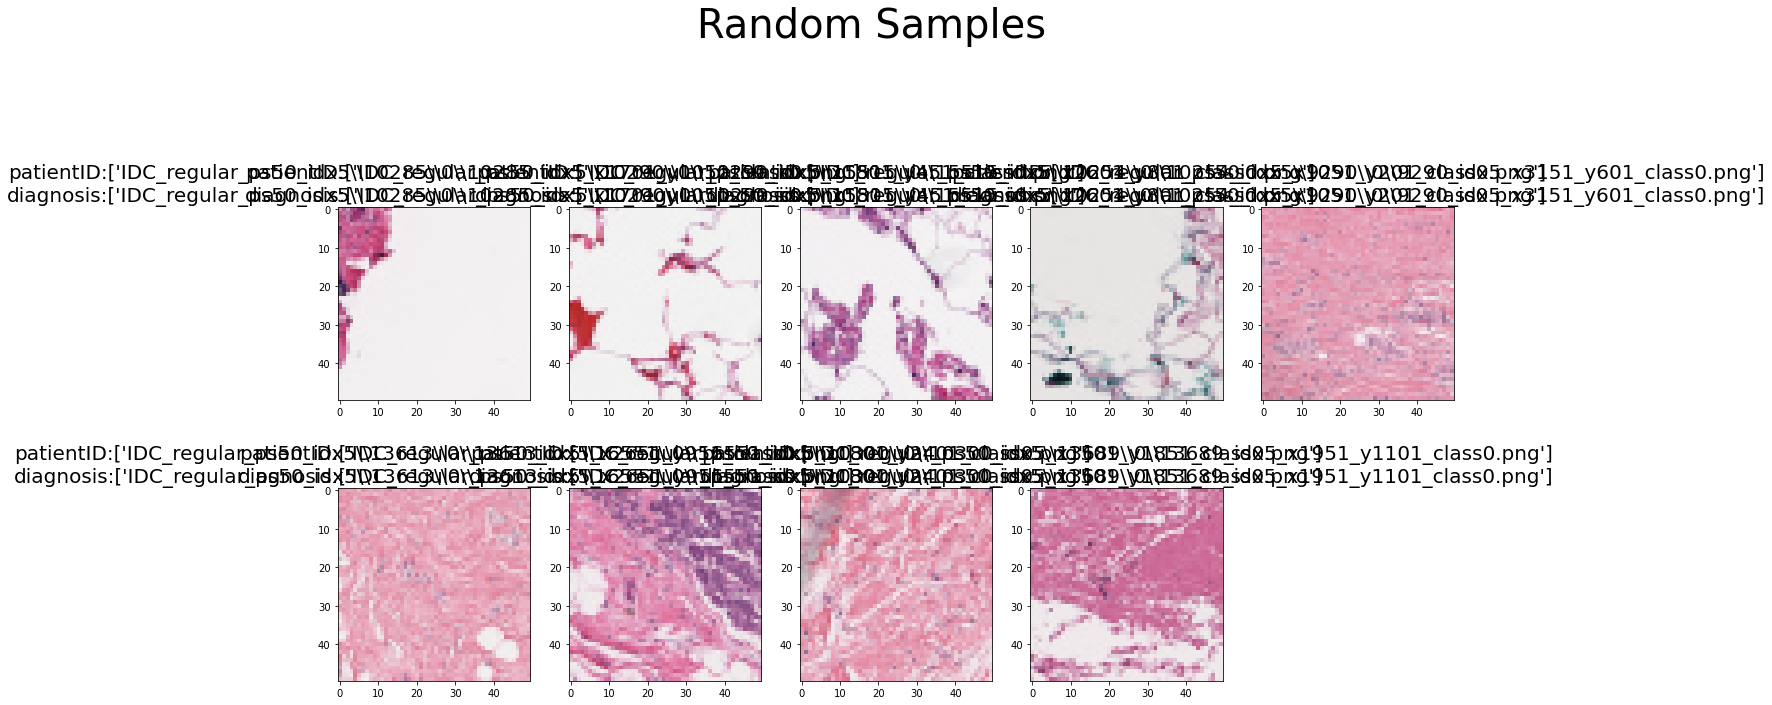

In [6]:
from random import choice
fig,axes = plt.subplots(figsize=(20,25))
  
ran_sample = [choice(class0)for x in range(0,10) ]
for i in range(0,len(ran_sample)):
    img = imread(ran_sample[i])
    plt.imshow(img)
    axes =plt.subplot(5,5,i+1)
    axes.set_title('patientID:'+str(ran_sample[i].split('/'))+'\n'+'diagnosis:'+str(ran_sample[i].split('/')),fontsize=20)

# There was a blank plot 
# so remove it via 'delaxes'
fig.delaxes(axes)
fig.suptitle('Random Samples ',fontsize=40)
plt.show() 

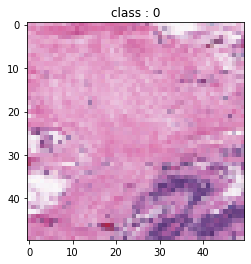

In [7]:
img_sample = imread(class0[0])
plt.title("class : 0")
plt.imshow(img_sample)

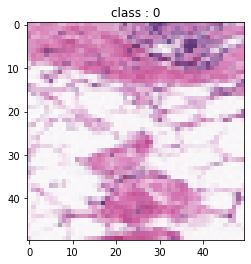

In [8]:
img_sample = imread(class0[1])
plt.title("class : 0")
plt.imshow(img_sample)

In [9]:
sampled_class0 = random.sample(class0, len(class1))
sampled_class1 = random.sample(class1, len(class1))

print("Class 0 :", len(sampled_class0))
print("Class 1 :", len(sampled_class1))

Class 0 : 78786
Class 1 : 78786


In [10]:
def get_image_arrays(data, label):
    img_arrays = []
    for i in tqdm(range(len(data))):
        image = data[i]
        if image.endswith('.png'):
            img = cv2.imread(image ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (50, 50), interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label])
    return img_arrays

In [11]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)

del sampled_class0
del sampled_class1
del class0
del class1
del imagePatches

  0%|          | 0/78786 [00:00<?, ?it/s]

  0%|          | 0/78786 [00:00<?, ?it/s]

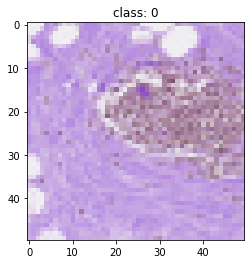

In [12]:
img_sample = class0_array[0][0]
plt.title('class: 0')
plt.imshow(img_sample)

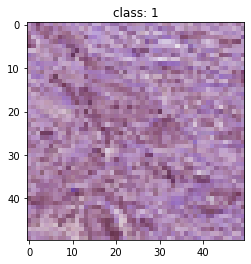

In [13]:
img_sample = class1_array[0][0]
plt.title('class: 1')
plt.imshow(img_sample)

In [14]:
combined_data = np.concatenate((class0_array, class1_array))

random.seed(18)
random.shuffle(combined_data)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [15]:
X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)
    
del combined_data

In [16]:
print(X[0])

[[[239 240 241]
  [241 242 240]
  [240 236 241]
  ...
  [185 151 224]
  [190 156 222]
  [197 163 226]]

 [[241 238 242]
  [237 237 242]
  [241 236 242]
  ...
  [192 158 224]
  [188 152 225]
  [194 163 223]]

 [[239 237 239]
  [239 234 242]
  [206 181 227]
  ...
  [180 141 225]
  [188 153 224]
  [189 154 226]]

 ...

 [[199 169 227]
  [192 156 225]
  [196 163 226]
  ...
  [189 154 227]
  [193 157 224]
  [208 182 230]]

 [[201 171 228]
  [190 160 226]
  [204 174 229]
  ...
  [194 162 227]
  [198 171 228]
  [198 168 231]]

 [[201 178 231]
  [200 166 231]
  [219 214 236]
  ...
  [201 172 229]
  [203 174 228]
  [205 178 228]]]


In [17]:
X = np.array(X)
y = np.array(y)

print(" Shape X : ", X.shape)
print(" Shape y : ", y.shape)

 Shape X :  (157572, 50, 50, 3)
 Shape y :  (157572,)


In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=18)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

np.save("X_train.npy" , X_train,)
np.save("X_val.npy" , X_val,)
np.save("y_train.npy" , y_train,)
np.save("y_val.npy" , y_val,)
del X,y

print(" X_train : ", X_train.shape)
print(" y_train : ", y_train.shape)
print(" X_val : ", y_train.shape)
print(" y_tval : ", y_val.shape)

 X_train :  (126057, 50, 50, 3)
 y_train :  (126057, 2)
 X_val :  (126057, 2)
 y_tval :  (31515, 2)


In [19]:
X_train = np.load("./X_train.npy")
X_val = np.load("./X_val.npy")
y_train = np.load("./y_train.npy")
y_val = np.load('./y_val.npy')

print(" X_train : ", X_train.shape)
print(" y_train : ", y_train.shape)
print(" X_val : ", X_val.shape)
print(" y_tval : ", y_val.shape)

 X_train :  (126057, 50, 50, 3)
 y_train :  (126057, 2)
 X_val :  (31515, 50, 50, 3)
 y_tval :  (31515, 2)


In [20]:
base_model_VGG = tf.keras.applications.VGG16(
    input_shape=(50,50,3),
    include_top=False,
    weights="imagenet"
)

In [21]:
base_model_resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(50,50,3),
)

In [27]:
base_model_efficient = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(50,50,3),
)

In [23]:
base_model_densenet = tf.keras.applications.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(50,50,3),
)

29089792/29084464 [==============================] - 5s 0us/step


In [28]:
base_models = [base_model_resnet, base_model_VGG, base_model_efficient, base_model_densenet]

for base_model in base_models:
    for layer in base_model.layers[:-5]:
        layer.trainable=False

In [29]:
# Building Model

def build_model(base_model,METRICS):
    model = tf.keras.Sequential([
        #tf.keras.layers.Input(shape=(None,50,50,3)),
        tf.keras.layers.Lambda(lambda x: x/255),
        #keras.layers.Lambda(lambda x: x/255),
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2,activation='softmax')
    ])
    
    
    model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=METRICS)
#     try:
#         model.summary()
#     except: 
#         pass
    return model

In [30]:
#build_model(base_model_VGG,METRICS)

In [31]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    
    fig, (ax1, ax2, ax3,ax4) = plt.subplots(1,4, figsize= (20,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    plt.show()

In [32]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.75, min_lr = 1e-10)
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=5)

def fit_model(base, name, epochs,METRICS):
    base_model = base_models[base]
    print(f"Training using {name} model")
    
    model = build_model(base_model,METRICS)
    
    history = model.fit(X_train, y_train,
                        batch_size=128,
                        validation_data=(X_val, y_val),
                        verbose = 1,epochs = 5,
                        callbacks=[lrd,mcp,es]
                       )
    
    model.summary()
    
    Train_Val_Plot(history)

Training using RESNET50 model
Epoch 1/5
985/985 [==============================] - 2036s 2s/step - loss: 0.3625 - accuracy: 0.8547 - precision: 0.8547 - recall: 0.8547 - auc: 0.9178 - val_loss: 0.4203 - val_accuracy: 0.8521 - val_precision: 0.8521 - val_recall: 0.8521 - val_auc: 0.9191
Epoch 2/5
985/985 [==============================] - 1916s 2s/step - loss: 0.3323 - accuracy: 0.8675 - precision: 0.8675 - recall: 0.8675 - auc: 0.9299 - val_loss: 0.3603 - val_accuracy: 0.8554 - val_precision: 0.8554 - val_recall: 0.8554 - val_auc: 0.9280
Epoch 3/5
985/985 [==============================] - 1595s 2s/step - loss: 0.3266 - accuracy: 0.8697 - precision: 0.8697 - recall: 0.8697 - auc: 0.9319 - val_loss: 0.4433 - val_accuracy: 0.8497 - val_precision: 0.8497 - val_recall: 0.8497 - val_auc: 0.9043
Epoch 4/5
985/985 [==============================] - 3861s 4s/step - loss: 0.3218 - accuracy: 0.8710 - precision: 0.8710 - recall: 0.8710 - auc: 0.9342 - val_loss: 0.3264 - val_accuracy: 0.8700 - val

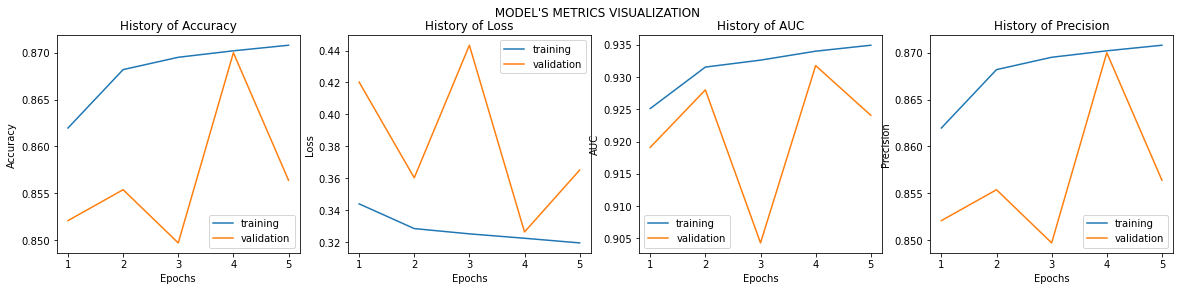

In [33]:
fit_model(0, "RESNET50", 5,METRICS)

Training using VGG model
Epoch 1/5
985/985 [==============================] - 4395s 4s/step - loss: 0.3187 - accuracy: 0.8705 - precision: 0.8705 - recall: 0.8705 - auc: 0.9323 - val_loss: 0.2552 - val_accuracy: 0.9004 - val_precision: 0.9004 - val_recall: 0.9004 - val_auc: 0.9562
Epoch 2/5
985/985 [==============================] - 4795s 5s/step - loss: 0.2432 - accuracy: 0.9040 - precision: 0.9040 - recall: 0.9040 - auc: 0.9601 - val_loss: 0.2387 - val_accuracy: 0.9063 - val_precision: 0.9063 - val_recall: 0.9063 - val_auc: 0.9600
Epoch 3/5
985/985 [==============================] - 4159s 4s/step - loss: 0.2253 - accuracy: 0.9097 - precision: 0.9097 - recall: 0.9097 - auc: 0.9650 - val_loss: 0.2280 - val_accuracy: 0.9105 - val_precision: 0.9105 - val_recall: 0.9105 - val_auc: 0.9639
Epoch 4/5
985/985 [==============================] - 4030s 4s/step - loss: 0.2034 - accuracy: 0.9215 - precision: 0.9215 - recall: 0.9215 - auc: 0.9698 - val_loss: 0.2271 - val_accuracy: 0.9110 - val_prec

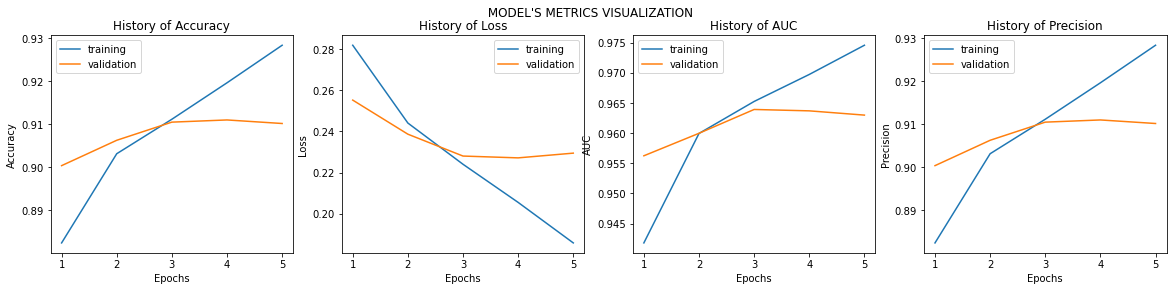

In [34]:
fit_model(1, "VGG", 5, METRICS)

Training using EFFICIENTB0 model
Epoch 1/5
985/985 [==============================] - 810s 809ms/step - loss: 0.4604 - accuracy: 0.8706 - precision: 0.8706 - recall: 0.8706 - auc: 0.9053 - val_loss: 0.4450 - val_accuracy: 0.8482 - val_precision: 0.8482 - val_recall: 0.8482 - val_auc: 0.8488
Epoch 2/5
985/985 [==============================] - 794s 806ms/step - loss: 0.4343 - accuracy: 0.8464 - precision: 0.8464 - recall: 0.8464 - auc: 0.8467 - val_loss: 0.4338 - val_accuracy: 0.8482 - val_precision: 0.8482 - val_recall: 0.8482 - val_auc: 0.8633
Epoch 3/5
985/985 [==============================] - 792s 804ms/step - loss: 0.4331 - accuracy: 0.8457 - precision: 0.8457 - recall: 0.8457 - auc: 0.8476 - val_loss: 0.4324 - val_accuracy: 0.8482 - val_precision: 0.8482 - val_recall: 0.8482 - val_auc: 0.8581
Epoch 4/5
985/985 [==============================] - 793s 805ms/step - loss: 0.4282 - accuracy: 0.8479 - precision: 0.8479 - recall: 0.8479 - auc: 0.8510 - val_loss: 0.4246 - val_accuracy: 0

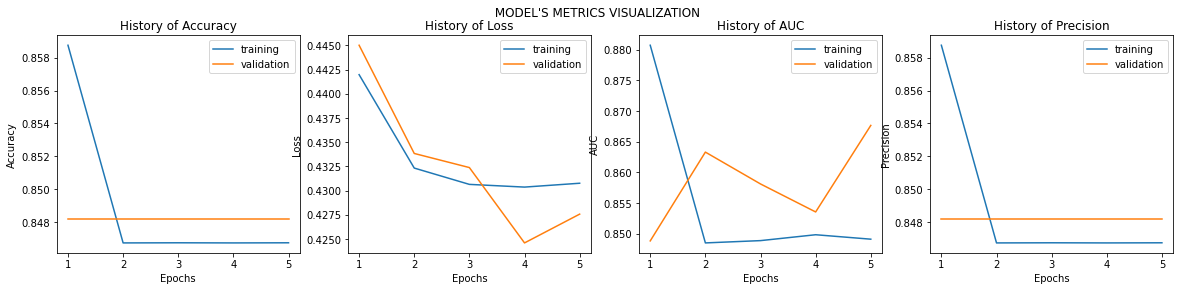

In [35]:
fit_model(2, "EFFICIENTB0", 5,METRICS)

Training using DENSENET121 model
Epoch 1/5
985/985 [==============================] - 1085s 1s/step - loss: 0.3465 - accuracy: 0.8646 - precision: 0.8646 - recall: 0.8646 - auc: 0.9148 - val_loss: 0.2756 - val_accuracy: 0.8917 - val_precision: 0.8917 - val_recall: 0.8917 - val_auc: 0.9505
Epoch 2/5
985/985 [==============================] - 1057s 1s/step - loss: 0.2737 - accuracy: 0.8933 - precision: 0.8933 - recall: 0.8933 - auc: 0.9510 - val_loss: 0.2730 - val_accuracy: 0.8921 - val_precision: 0.8921 - val_recall: 0.8921 - val_auc: 0.9521
Epoch 3/5
985/985 [==============================] - 1049s 1s/step - loss: 0.2658 - accuracy: 0.8947 - precision: 0.8947 - recall: 0.8947 - auc: 0.9536 - val_loss: 0.2662 - val_accuracy: 0.8945 - val_precision: 0.8945 - val_recall: 0.8945 - val_auc: 0.9531
Epoch 4/5
985/985 [==============================] - 1020s 1s/step - loss: 0.2632 - accuracy: 0.8976 - precision: 0.8976 - recall: 0.8976 - auc: 0.9539 - val_loss: 0.2667 - val_accuracy: 0.8943 - 

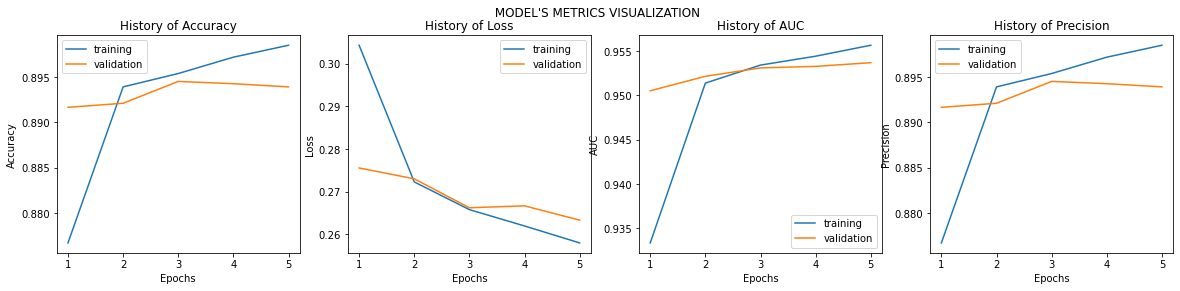

In [36]:
fit_model(3, "DENSENET121", 5,METRICS)